In [1]:
import os
import seaborn as sns
path = '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Analysis/Figures'
import sys
sys.path.insert(1, '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Data Collection')
from configs import *
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# from mpl_toolkits.axisartist.axislines import SubplotZero
# from pylab import text
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "lualatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

from sqlalchemy import create_engine

engine = create_engine('mysql+mysqlconnector://'+user+':'+passwd+'@'+ip+':3306/'+schema1)

In [2]:
stmt = ''' SELECT 
DATE_FORMAT(A.date, \'%Y-%m\') as date, 
COUNT(1) as num_tweets,
AVG(B.mnb_prediction) AS mnb,
AVG(B.svm_prediction) AS svm,
AVG(B.lr_prediction) AS lr,
AVG(B.ensemble_prediction) AS ens
FROM social.machine_learning_only A
INNER JOIN social.ML_sentiment B 
ON A.id = B.id
GROUP BY DATE_FORMAT(A.date, \'%Y-%m\')
ORDER BY DATE_FORMAT(A.date, \'%Y-%m\') ASC'''

df = pd.read_sql(stmt, con=engine)
df['date'] = pd.to_datetime(df['date'])

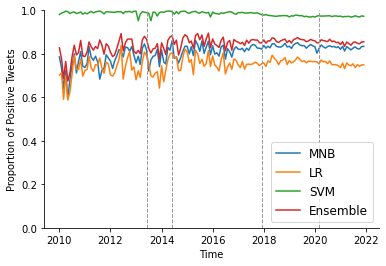

In [3]:
ax = plt.gca()
line = pd.to_datetime('2013-06-01')
line2 = pd.to_datetime('2014-06-01')
line3 = pd.to_datetime('2017-12-01')
line4 = pd.to_datetime('2020-03-01')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
ax.set_ylim([0,1])
plt.xlabel('Time')
plt.ylabel('Proportion of Positive Tweets')
plt.plot(df.date, df.mnb, label = 'MNB')
plt.plot(df.date, df.lr, label = 'LR')
plt.plot(df.date, df.svm, label = 'SVM')
plt.plot(df.date, df.ens, label = 'Ensemble')
plt.axvline(x=line, c = '#999999', linewidth = 1, linestyle ="--")
plt.axvline(x=line2, c = '#999999', linewidth = 1, linestyle ="--")
plt.axvline(x=line3, c = '#999999', linewidth = 1, linestyle ="--")
plt.axvline(x=line4, c = '#999999', linewidth = 1, linestyle ="--")
plt.legend(loc='lower right')
# plt.savefig(os.path.join(path, 'ml_sentiment.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
# plt.close()

In [4]:
stmt = '''  SELECT 
A.text
FROM social.machine_learning_only A
INNER JOIN social.ML_sentiment B 
ON A.id = B.id
WHERE ensemble_prediction = 0'''

negative_df = pd.read_sql(stmt, con=engine)

In [5]:
stmt = '''  SELECT 
A.text
FROM social.machine_learning_only A
INNER JOIN social.ML_sentiment B 
ON A.id = B.id
WHERE ensemble_prediction = 1'''

positive_df = pd.read_sql(stmt, con=engine)

total_positive_tweets = len(positive_df.index)

In [6]:
from collections import Counter

negative_words = Counter(" ".join(negative_df["text"]).split()).most_common(1000)

positive_words = Counter(" ".join(positive_df["text"]).split()).most_common(1000)

In [7]:
neg_df = pd.DataFrame(negative_words, columns=['neg_word', "neg_word_count"])
pos_df = pd.DataFrame(positive_words, columns=['pos_word', "pos_word_count"])

In [8]:
merged_df= pd.merge(neg_df, pos_df, left_on='neg_word', right_on='pos_word', how='inner')

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.append('learning')
stop_words.append('machine')

for i in range(len(merged_df.index)):
    if str(merged_df.neg_word[i]) in stop_words:
        merged_df = merged_df.drop(i)

In [10]:
merged_df.reset_index(drop=True)

,neg_word,neg_word_count,pos_word,pos_word_count
0,data,218601,data,566608
1,science,94229,science,177311
2,machinelearning,93401,machinelearning,598956
3,ai,92834,ai,939058
4,ml,35018,ml,266853
...,...,...,...,...
602,unsupervised,1064,unsupervised,14603
603,across,1054,across,15198
604,opportunity,1053,opportunity,13106
605,give,1052,give,10711


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

merged_df[['neg_word_count_norm', 'pos_word_count_norm']] = scaler.fit_transform(merged_df[['neg_word_count', 'pos_word_count']])

In [12]:
unmerged_pos = merged_df.iloc[:, [2,3, 5]].sort_values(by=['pos_word_count'], ascending=False)
unmerged_neg = merged_df.iloc[:, [0,1, 4]].sort_values(by=['neg_word_count'], ascending=False)

In [43]:
top_10_pos = unmerged_pos.head(10).pos_word.values

In [44]:
top_10_neg = unmerged_neg.head(10).neg_word.values

In [45]:
top_words = list(top_10_pos)
top_words.extend(x for x in top_10_neg if x not in top_words)

In [46]:
f = []
for i in range(len(merged_df.index)):
    if merged_df.neg_word.values[i] in top_words:
        f.append(i)
        

In [47]:
final_df = merged_df.iloc[f,:]

Text(0, 0.5, 'Normalised Count in Positive Tweets')

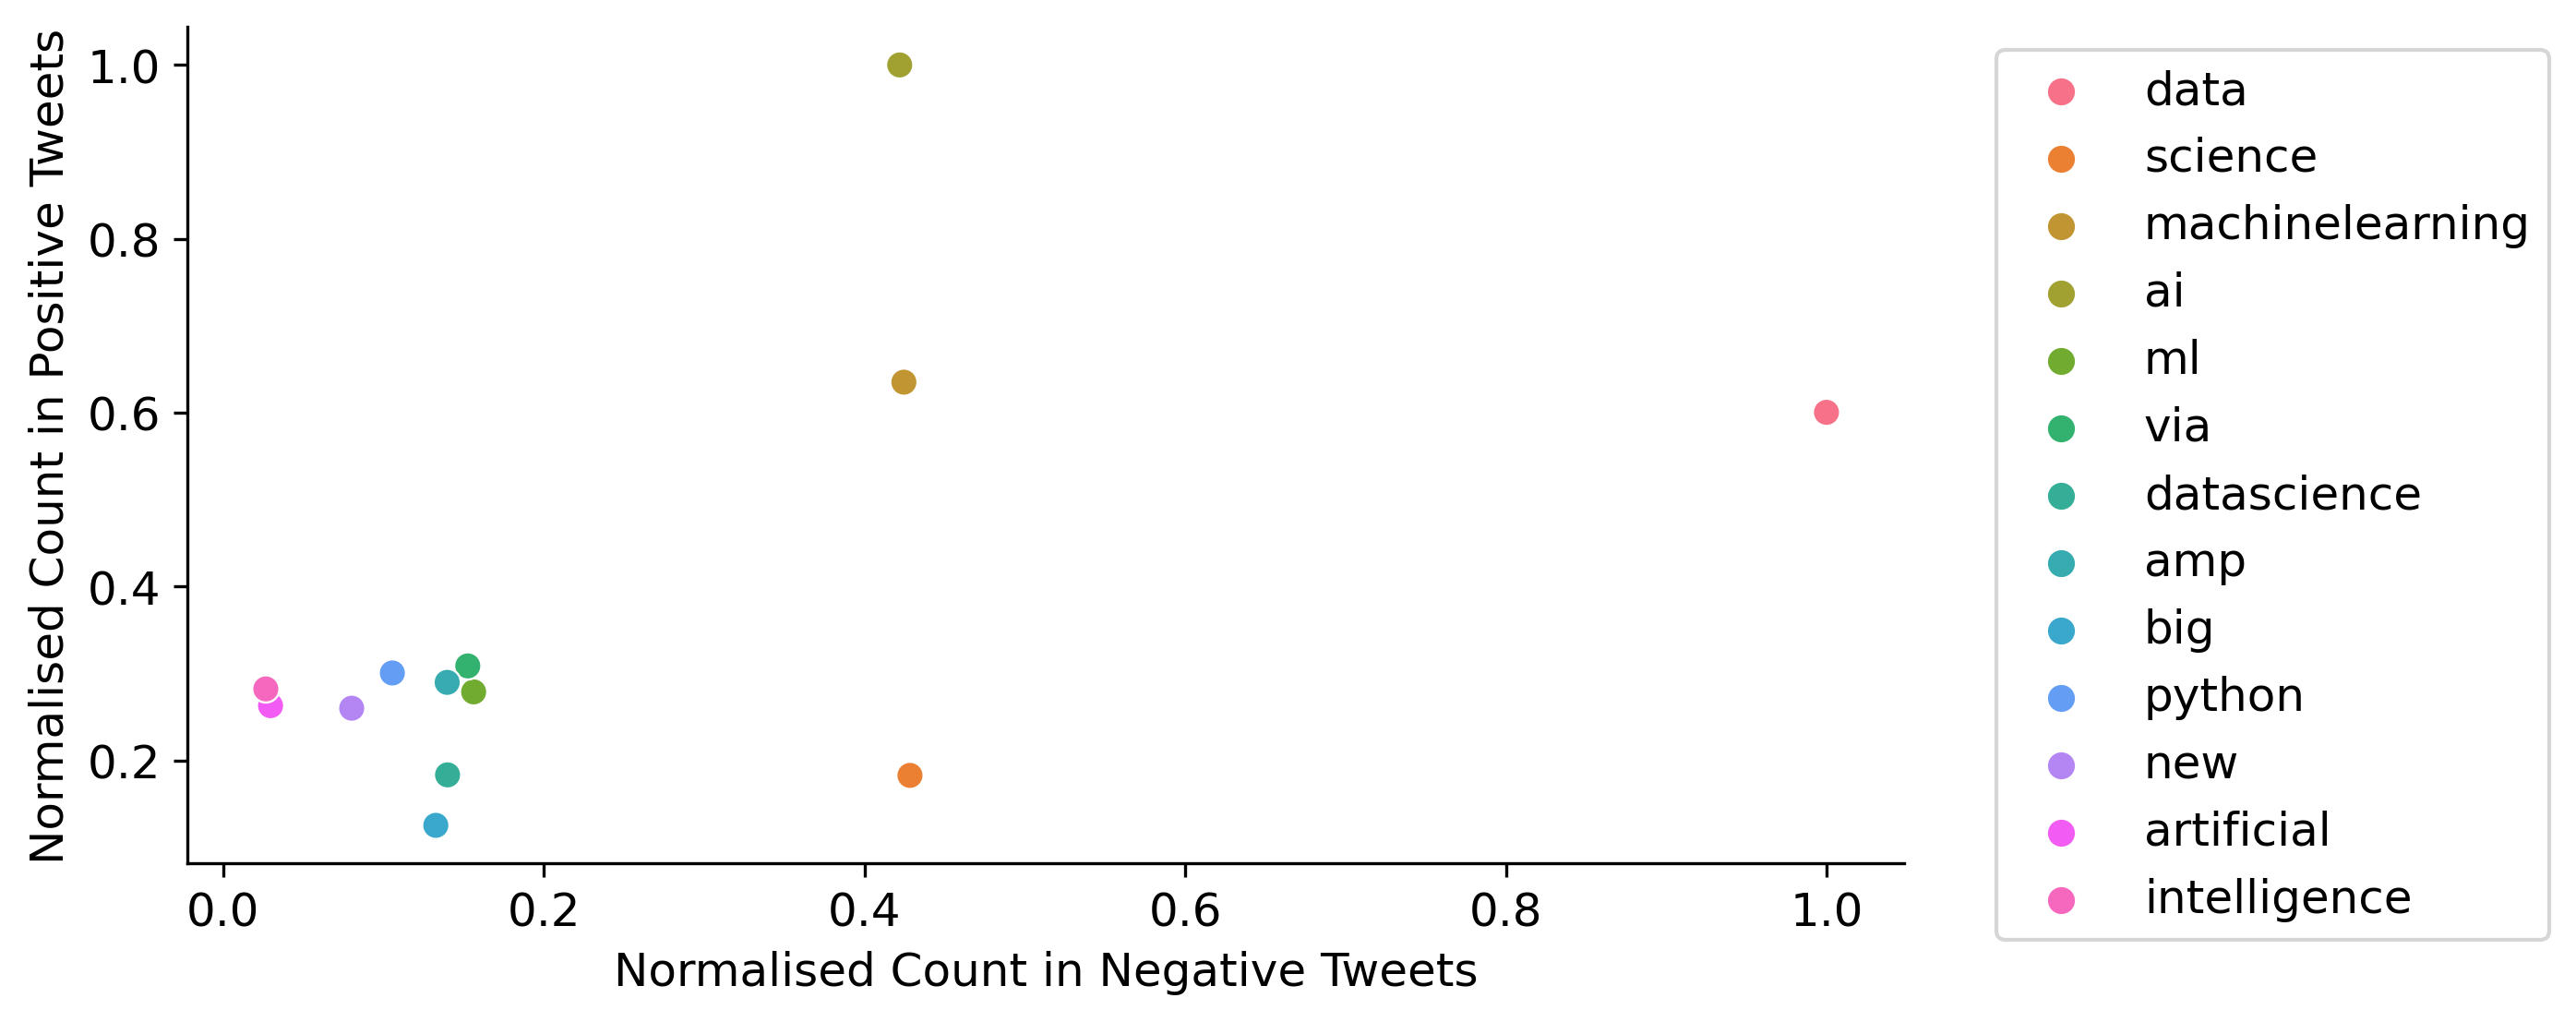

In [48]:
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
ax = sns.scatterplot(x='neg_word_count_norm',y='pos_word_count_norm',hue = 'neg_word',data = final_df,legend='full',s=50)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel('Normalised Count in Negative Tweets')
plt.ylabel('Normalised Count in Positive Tweets')
# plt.savefig(os.path.join(path, 'ml_word_occurrence.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
# plt.close()

In [55]:
final_df

,neg_word,neg_word_count,pos_word,pos_word_count,neg_word_count_norm,pos_word_count_norm
3,data,218601,data,566608,1.000000,0.600510
11,science,94229,science,177311,0.428314,0.182949
12,machinelearning,93401,machinelearning,598956,0.424508,0.635206
13,ai,92834,ai,939058,0.421902,1.000000
24,ml,35018,ml,266853,0.156146,0.278992
25,via,34220,via,294690,0.152478,0.308850
28,datascience,31478,datascience,177868,0.139874,0.183547
29,amp,31426,amp,277056,0.139635,0.289936
31,big,29884,big,123758,0.132547,0.125508
35,python,23985,python,287146,0.105432,0.300758


<ipython-input-68-13e102ffb443>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim([0,1000000])
<ipython-input-68-13e102ffb443>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0,1500000])


Text(0, 0.5, 'Normalised Count in Positive Tweets')

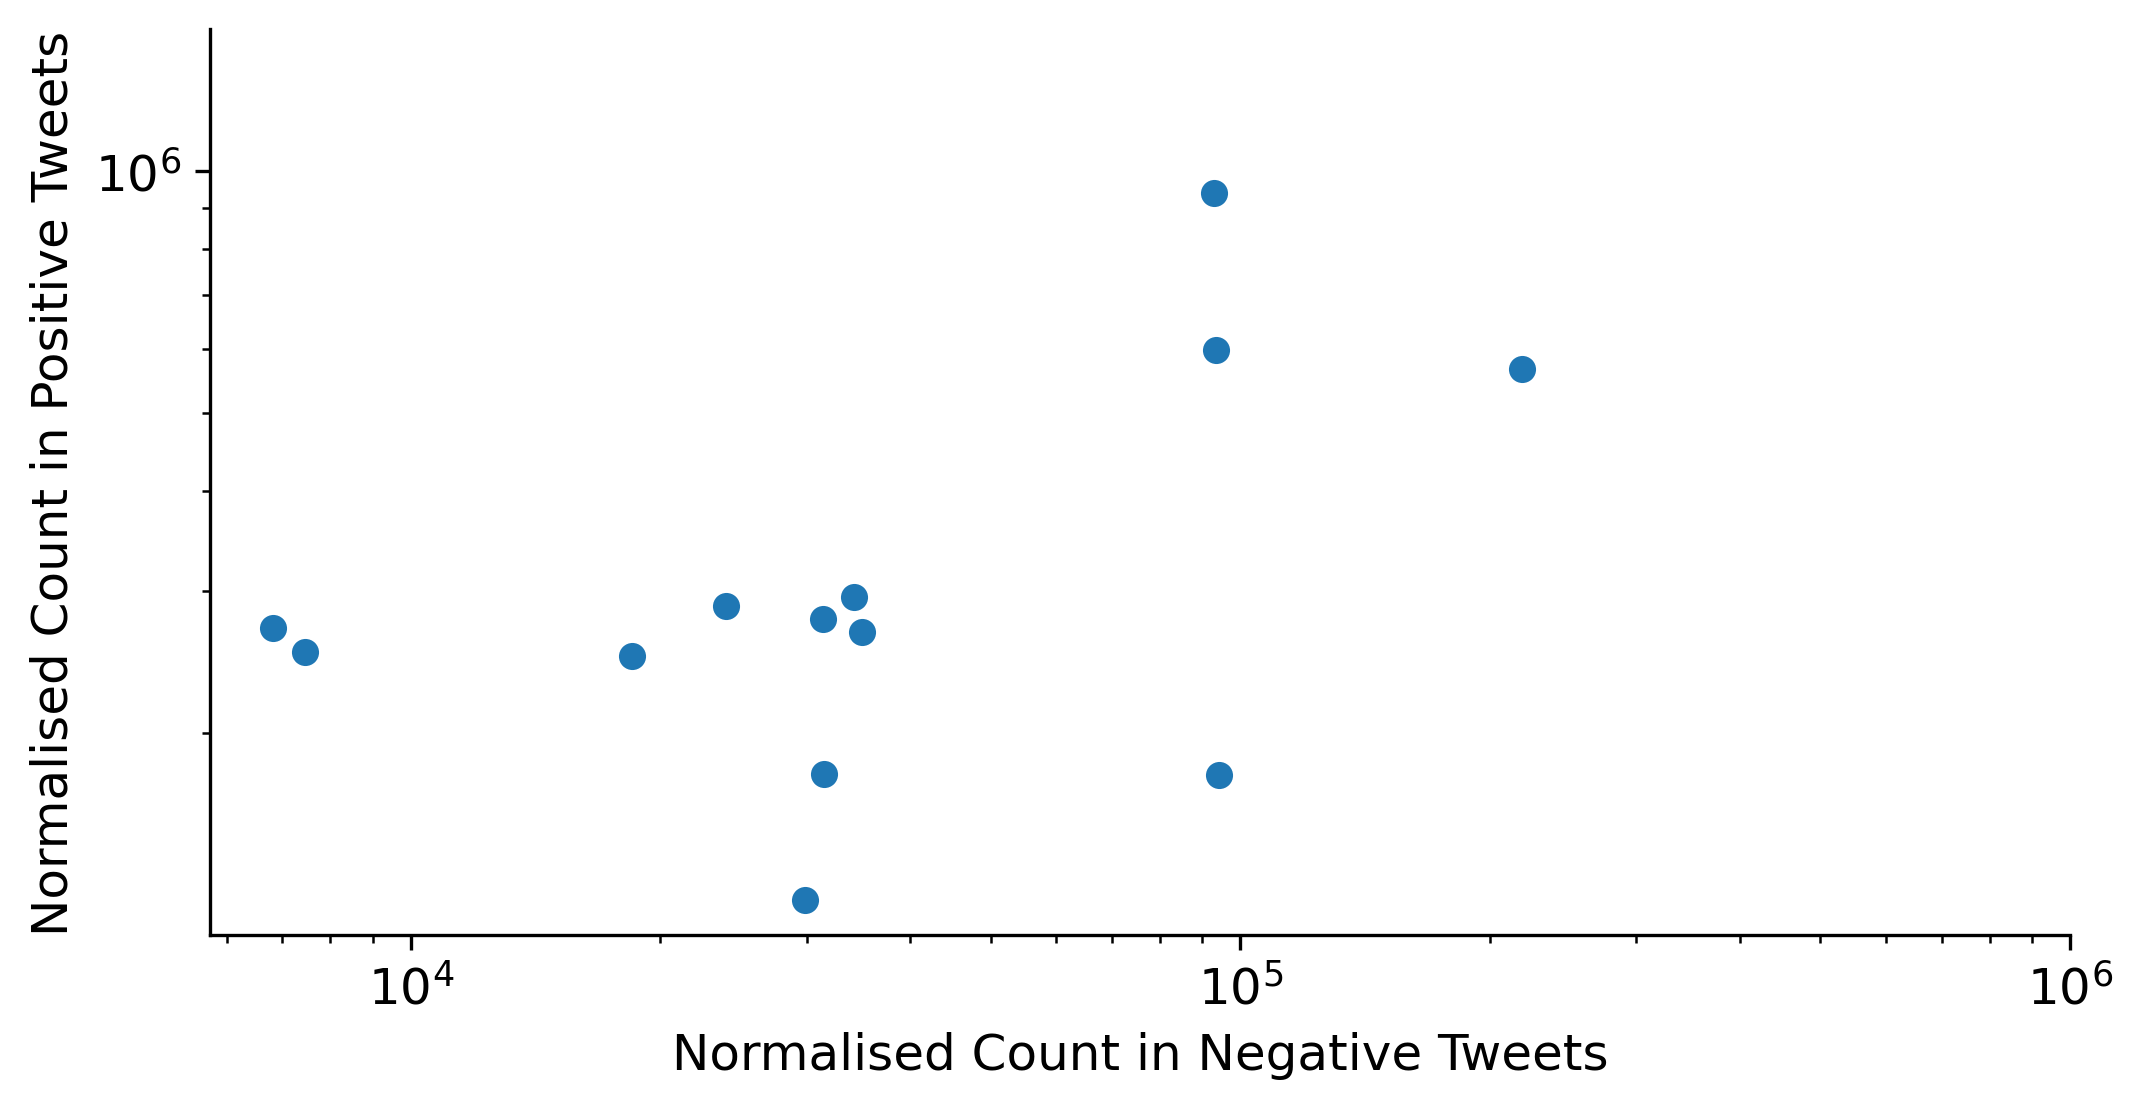

In [68]:
xscale="log"

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
ax = sns.scatterplot(x='neg_word_count',y='pos_word_count',data = final_df,s=50)
ax.set(xscale="log")
ax.set(yscale="log")
ax.set_xlim([0,1000000])
ax.set_ylim([0,1500000])


# for i in final_df.index:
#     label = final_df.neg_word[i]
#     x = final_df.neg_word_count[i]
#     y = final_df.pos_word_count[i]
#     m = 1.1
#     if label == 'data':
#         m = -1.1
#     else:
#         m = 1.1

#     plt.annotate(label, (x, m*y))







# final_df[['neg_word_count','pos_word_count','pos_word']].apply(lambda x: ax.text(*x),axis=1)
# ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel('Normalised Count in Negative Tweets')
plt.ylabel('Normalised Count in Positive Tweets')
# plt.savefig(os.path.join(path, 'ml_word_occurrence_log.pdf'), format='pdf',bbox_inches='tight',pad_inches = 0)
# plt.close()